In [1]:
import sys
sys.path.append('../../')
from layer_for_theano import *
#print __layer_version__

In [2]:
import cPickle
import numpy as np
import gzip

import time

class dataset_mnist_small:
    def __init__(self):
        if 0: # no requirement for gzip, but big file
            f = open('mnist_14x14.pkl', 'rb')
            train_set, valid_set, test_set = cPickle.load(f)
            f.close()
        else: # requiring gzip           
            f = gzip.open('mnist_14x14.pkl.gz','rb')
            train_set, valid_set, test_set = cPickle.load(f)
            f.close()

        self.xs_tr, ys_tr = train_set
        self.xs_val, ys_val = valid_set
        self.xs_te, ys_te = test_set

        self.ys_tr =  ys_tr.astype(np.int32)
        self.ys_val = ys_val.astype(np.int32)
        self.ys_te =  ys_te.astype(np.int32)

t0 = time.time()
        
ds =  dataset_mnist_small()  
print 'load dataset in %.1f secs' % (time.time()-t0)

print ds.xs_tr.shape


load dataset in 2.7 secs
(50000L, 196L)


In [4]:
def get_update_rmsprop(loss, all_parameters, learning_rate):
    #all_grads = [theano.grad(loss, param) for param in all_parameters]
    all_grads = T.grad(loss, all_parameters)
    updates = []
    for p, g in zip(all_parameters, all_grads):
        MeanSquare = theano.shared(p.get_value() * 0.)
        nextMeanSquare = 0.9 * MeanSquare + (1 - 0.9) * g ** 2
        g = g / T.sqrt(nextMeanSquare + 0.000001)
        updates.append((MeanSquare, nextMeanSquare))
        updates.append((p, p - learning_rate * g))
    return updates

In [5]:
from sgd_for_theano import *
class mlp_rmsprop(tt_sgd_model):
    def __init__(self):
        #784
        dim = 196
        nc = 10

        self.layers = []
        self.layers += [InputLayer(dim)]

        nonlinearfunc = T.tanh #T.nnet.sigmoid #rectify #rectify
        print 'nonlinear activation function = ', nonlinearfunc
        self.layers += [ HiddenLayer(self.layers[-1], n_out = 500,  activation = T.tanh)]
        self.layers += [ HiddenLayer(self.layers[-1], n_out = nc,  activation = None)]
        self.layers +=  [ SoftmaxLayer(self.layers[-1])]

        self.target = T.ivector('target')
        output_eval = self.layers[-1].output()
        self.cost_eval = mcloss_negli(output_eval, self.target)
        self.err_eval = mc_error(output_eval, self.target)
        self.validate_model = theano.function([self.layers[0].input, self.target], self.err_eval)
        self.cost_model = theano.function([self.layers[0].input,self. target], self.cost_eval)

        output_tr = self.layers[-1].output(dropout_training=True)
        self.cost_tr = mcloss_negli(output_eval, self.target)

        learning_rate = 0.13
        #all_para = all_parameters(self.layers[-1])
        all_para = self.get_all_parameters()
        #updates = gen_updates_sgd(self.cost_tr, all_para, learning_rate)
        updates = get_update_rmsprop(self.cost_tr, all_para, learning_rate)
        
        
        self.all_para = all_para        
        self.train_model = theano.function([self.layers[0].input, self.target], self.cost_tr, updates=updates)

model = mlp_rmsprop()

if 1: #unit test
    import sys
    model._unit_test(ds.xs_tr[0:100], ds.ys_tr[0:100])
    #sys.exit(0)

nonlinear activation function =  Elemwise{tanh,no_inplace}
before training, err= 0.91
now training, cost =  2.36644118306
after training, err= 0.77


In [15]:
paras = model.all_para
grad = T.grad(model.cost_tr, paras)

for p, g in zip(paras,grad):
    #p0 = p.eval({model.layers[0].input: ds.xs_tr[0:1]})
    #g0 = g.eval({model.layers[0].input: ds.xs_tr[0:1]})
    p0 = p.get_value()
    g0 = g.eval({model.layers[0].input: ds.xs_tr[0:1], model.target: ds.ys_tr[0:1]})
    print p0.shape, g0.shape

(500L, 10L) (500L, 10L)
(10L,) (10L,)
(196L, 500L) (196L, 500L)
(500L,) (500L,)


In [6]:
best_err, best_model,err_list_val, err_list_tr =  sgd_batch(model, ds.xs_tr, ds.ys_tr, ds.xs_te, ds.ys_te, batch_size=600, n_epochs=10)


 epoch 1, minibatch 84/84, validation error 0.228922  training error 0.236409

 epoch 2, minibatch 84/84, validation error 0.324853  training error 0.320258

 epoch 3, minibatch 84/84, validation error 0.183137  training error 0.187123

 epoch 4, minibatch 84/84, validation error 0.170931  training error 0.172321

 epoch 5, minibatch 84/84, validation error 0.063775  training error 0.060397

 epoch 6, minibatch 84/84, validation error 0.091373  training error 0.092560

 epoch 7, minibatch 84/84, validation error 0.107549  training error 0.102004

 epoch 8, minibatch 84/84, validation error 0.060490  training error 0.054762

 epoch 9, minibatch 84/84, validation error 0.073137  training error 0.067381

 epoch 10, minibatch 84/84, validation error 0.062500  training error 0.054841


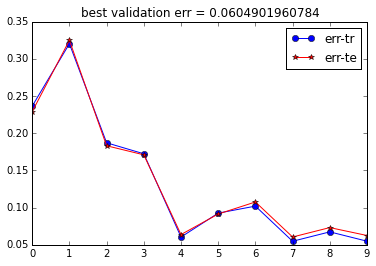

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(err_list_tr,'bo-',label='err-tr')
plt.plot(err_list_val,'r*-',label='err-te')
plt.legend()
plt.title('best validation err = ' + str(best_err))
plt.show()